In [24]:
# =====================================================
# Urban Heat Island Patch Extraction - Test Notebook
# =====================================================

import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.windows import from_bounds
from rasterio.warp import transform_bounds

# ---------- Parameters ----------
DAY = 196                    
PATCH_SIZE = 16            
STRIDE = 8                    
NAN_THRESHOLD = 0.3            
TEMP_THRESHOLD = 303.0         
HOT_RATIO = 0.5                 
OUTPUT_DIR = '../data/processed'

os.makedirs(OUTPUT_DIR, exist_ok=True)

# ---------- DMV bounding box (in lat/lon) ----------
dmv_bounds_latlon = {
    'left':  -77.8,
    'right': -76.0,
    'bottom': 38.2,
    'top':    39.8
}


Reading: ../data/raw/gf_Day2020_196.tif
Cropped shape: (192, 330)
Temperature range: 135.0 - 410.0
NaN ratio: 0.14908459595959597


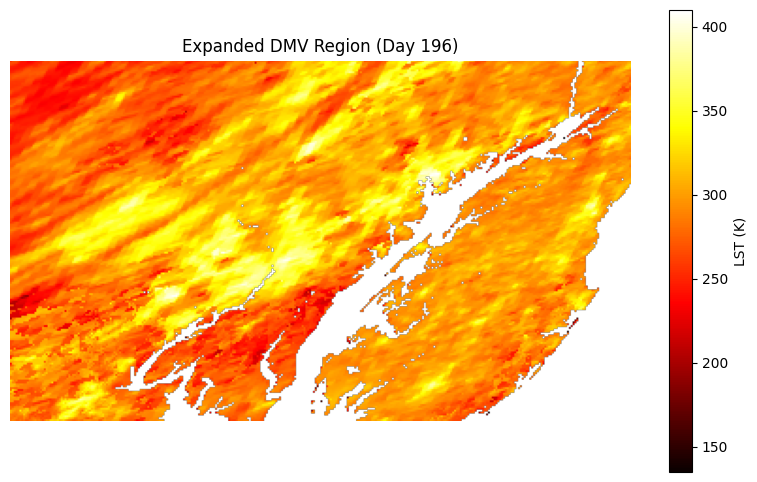

In [25]:
# ---------- Load and crop the LST .tif file ----------
tif_path = f'../data/raw/gf_Day2020_{DAY}.tif'
print("Reading:", tif_path)

with rasterio.open(tif_path) as src:
    # Convert geographic bounds to raster CRS
    dmv_bounds_proj = transform_bounds('EPSG:4326', src.crs,
                                       dmv_bounds_latlon['left'],
                                       dmv_bounds_latlon['bottom'],
                                       dmv_bounds_latlon['right'],
                                       dmv_bounds_latlon['top'])
    # Extract the target window
    window = from_bounds(*dmv_bounds_proj, transform=src.transform)
    patch = src.read(1, window=window).astype(np.float32)

# Replace invalid values with NaN
patch[patch <= 0] = np.nan

print("Cropped shape:", patch.shape)
print("Temperature range:", np.nanmin(patch), "-", np.nanmax(patch))
print("NaN ratio:", np.isnan(patch).mean())

plt.figure(figsize=(10,6))
plt.imshow(patch, cmap='hot')
plt.colorbar(label='LST (K)')
plt.title(f"Expanded DMV Region (Day {DAY})")
plt.axis('off')
plt.show()


In [29]:
# ---------- Sliding-window patch extraction + labeling ----------
H, W = patch.shape
patches, labels = [], []

for i in range(0, H - PATCH_SIZE + 1, STRIDE):
    for j in range(0, W - PATCH_SIZE + 1, STRIDE):
        sub = patch[i:i+PATCH_SIZE, j:j+PATCH_SIZE]
        # Skip patches with too many NaNs
        if np.isnan(sub).mean() <= NAN_THRESHOLD:
            valid = sub[~np.isnan(sub)]
            hot_ratio = (valid > TEMP_THRESHOLD).mean() if len(valid) else 0.0
            label = 1 if hot_ratio > HOT_RATIO else 0
            patches.append(sub)
            labels.append(label)

patches = np.array(patches, dtype=np.float32)
labels = np.array(labels, dtype=np.int64)

print(f"Total patches: {len(patches)}")
print(f"UHI: {(labels==1).sum()} | Non-UHI: {(labels==0).sum()}")

# Save patch and label arrays
np.save(f"{OUTPUT_DIR}/patches_day{DAY}_sw.npy", patches)
np.save(f"{OUTPUT_DIR}/labels_day{DAY}_sw.npy", labels)
print("Files saved successfully.")


Total patches: 767
UHI: 275 | Non-UHI: 492
Files saved successfully.


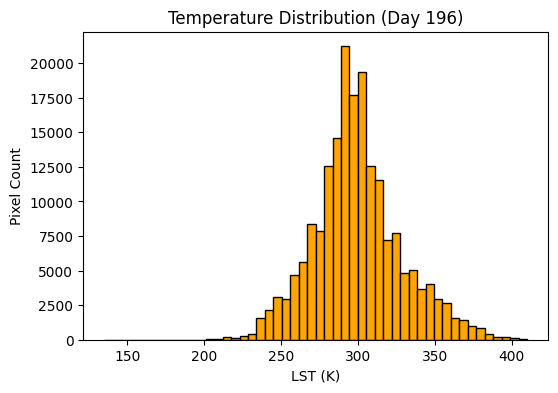

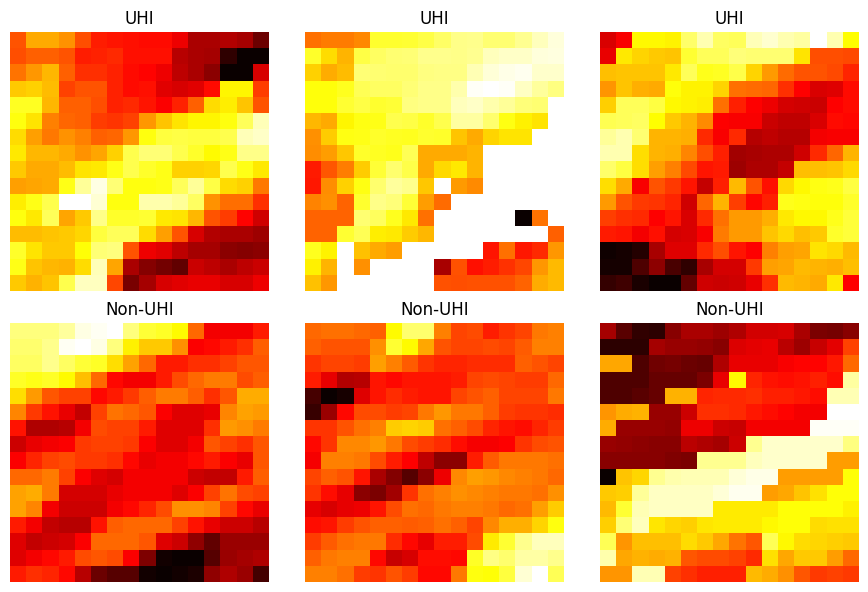

In [30]:
# ---------- Quick validation ----------
# 1) Temperature histogram
plt.figure(figsize=(6,4))
plt.hist(patches[~np.isnan(patches)].flatten(), bins=50, color='orange', edgecolor='k')
plt.title(f"Temperature Distribution (Day {DAY})")
plt.xlabel('LST (K)')
plt.ylabel('Pixel Count')
plt.show()

# 2) Random patch visualization
import random
fig, axes = plt.subplots(2, 3, figsize=(9,6))
hot_idx = np.where(labels==1)[0]
cold_idx = np.where(labels==0)[0]

for i in range(3):
    axes[0,i].imshow(patches[random.choice(hot_idx)], cmap='hot')
    axes[0,i].set_title("UHI")
    axes[0,i].axis('off')

    axes[1,i].imshow(patches[random.choice(cold_idx)], cmap='hot')
    axes[1,i].set_title("Non-UHI")
    axes[1,i].axis('off')

plt.tight_layout()
plt.show()
